<h1>Vector Autoregression Analysis</h1>
<h2>Modeling the Dynamic Interactions Between Multiple Variables</h2>
<p>In this analysis, we will explore the dynamic interactions between multiple variables using vector autoregression.</p>


In [24]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import pandas as pd
from datetime import datetime
import os

import matplotlib.pyplot as plt 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr

pd.set_option('display.max_columns', 500)
pd.set_option('mode.chained_assignment', None)



In [25]:
files = os.listdir('ssw_events_saved_filtered_2/')

In [26]:
# Load all data into one dataframe
df_all = pd.DataFrame()
for file in files:
    df = pd.read_csv("ssw_events_saved_filtered_2/" + file)
    # add an t_ column that is 0 for when SSW_flah is true and increases by 1 after that value and decreases by one before that value
    df = df.sort_values(by='dates', ascending=True)
    # add central date column, that identifies a dataset by its central date
    df['central_date'] = df.iloc[45].dates    
    # concat df with df_all
    df_all = pd.concat([df,df_all])
    


# sort df_all by dates
df_all = df_all.sort_values(by='dates', ascending=True)
# add an index column
df_all['index_'] = range(1, len(df_all) + 1)
# select year to a column
df_all['year'] = pd.DatetimeIndex(df_all['dates']).year
# load df_merged into a Pandas DataFrame and merge it with df_all
df_merged = pd.read_csv("df_merged.csv")
# merge df_all and df_merged on all common dates  
df_all = pd.merge(df_all, df_merged[['dates','mf_abs','mf_abs_zscore','mf_abs_zscore_abs']], on='dates', how='inner')


In [27]:
# =================================================================================================
# Plot absolute Momemtum flux with Plotly
# =================================================================================================

# group df by year and plot the mean of each year
df = df_all

df_grouped = df.groupby('central_date')

fig = go.Figure()

for year, dataframe in df_grouped:
    # plot the mean of each year using plotly
    fig.add_trace(go.Scatter(x=dataframe['t_delta'], y=dataframe['mf_abs'], name=f'Momentum Flux ({year})', line=dict(), yaxis='y2'))

    
fig.update_layout(
    yaxis=dict(
        range=[-20, 50],
        title='ZMZW in m/s'
    )
    ,yaxis2=dict(
        range=[-0.0, 0.005],
        title='Absolute Momentum Flux',
        side='right',
        overlaying='y'
    )
    ,xaxis=dict(title='Dates'),
    title=f'Plot Absolute Momentum Flux centered around the first day of a sudden Stratospheric Warming ',
    legend=dict(orientation="h", y=1.2, x=0.5))

# Show the plot
fig.show()

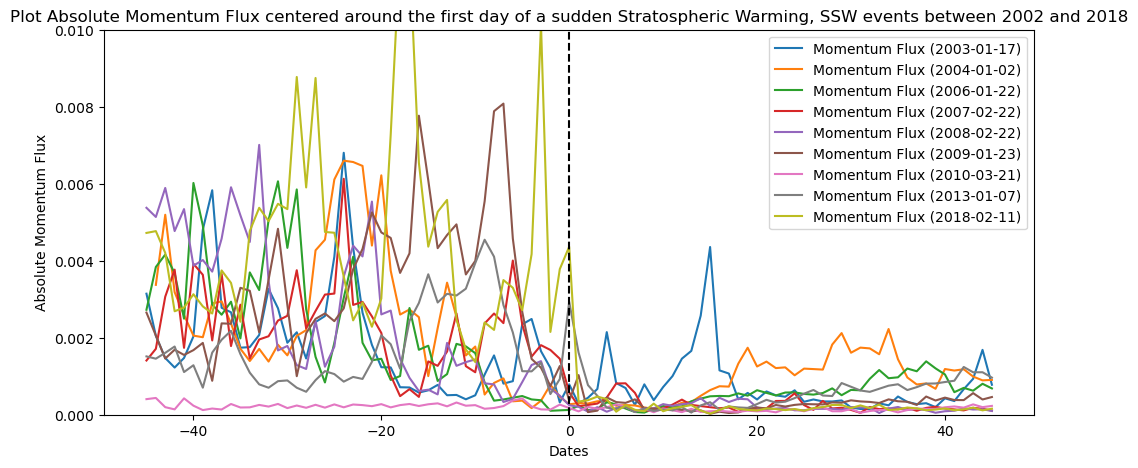

In [28]:
# =================================================================================================
# Plot absolute Momemtum flux with Matplotlib
# =================================================================================================

import matplotlib.pyplot as plt

df = df_all

df_grouped = df.groupby('central_date')

fig, ax1 = plt.subplots(figsize=(12, 5))

for year, dataframe in df_grouped:
    ax1.plot(dataframe['t_delta'], dataframe['mf_abs'], label=f'Momentum Flux ({year})')
    
# Set the axis labels and titles
ax1.set_xlabel('Dates')
ax1.set_ylabel('Absolute Momentum Flux')
ax1.set_ylim([-0.0, 0.0100])
ax1.tick_params(axis='y')

# add vertical line at t_delta = 0
ax1.axvline(x=0, color='black', linestyle='--')


plt.title('Plot Absolute Momentum Flux centered around the first day of a sudden Stratospheric Warming, SSW events between 2002 and 2018')
plt.legend(loc='upper right')

plt.show()


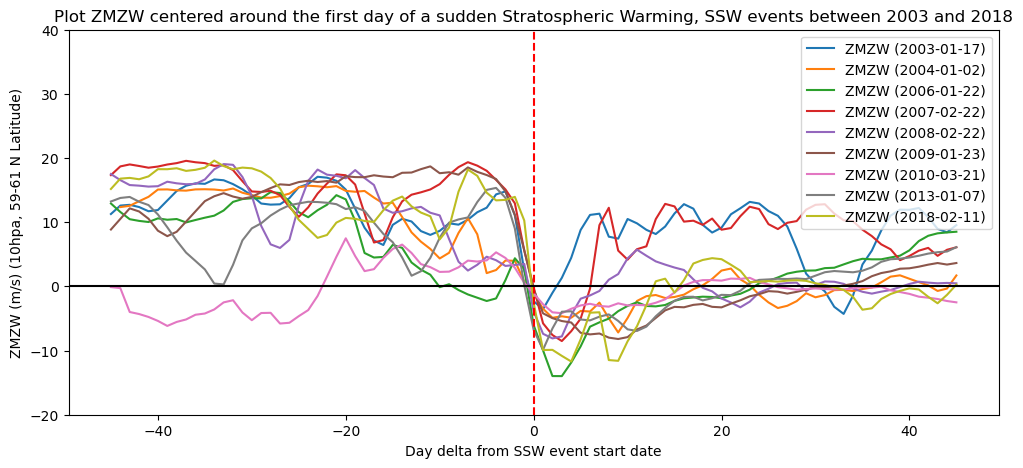

In [29]:
import matplotlib.pyplot as plt

plt.style.use('default')

df = df_all

df_grouped = df.groupby('central_date')

fig, ax1 = plt.subplots(figsize=(12, 5))

for year, dataframe in df_grouped:
    ax1.plot(dataframe['t_delta'], dataframe['wind_eastward_mean_cos'], label=f'ZMZW ({year})')
    
# Set the axis labels and titles
ax1.set_xlabel('Day delta from SSW event start date')
ax1.set_ylabel('ZMZW (m/s) (10hpa, 59-61 N Latitude)')
ax1.set_ylim([-20, 40])
ax1.tick_params(axis='y')

# add vertical line at t_delta = 0
ax1.axvline(x=0, color='red', linestyle='--')

# add horizontal line at y=0
ax1.axhline(y=0, color='black', linestyle='-')

plt.title('Plot ZMZW centered around the first day of a sudden Stratospheric Warming, SSW events between 2003 and 2018')
plt.legend(loc='upper right')

plt.show()


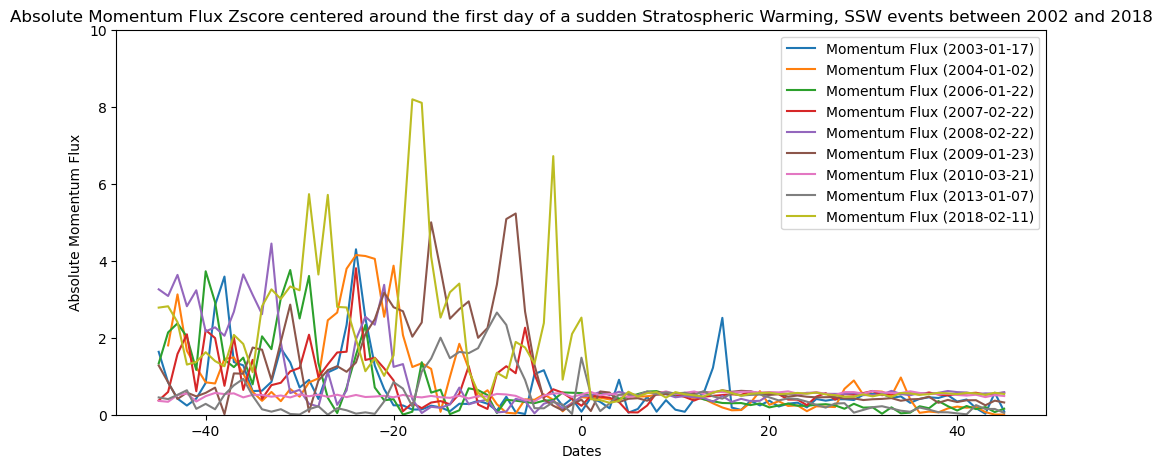

In [30]:
# =================================================================================================
# Plot absolute Zscore of momentum flux with Matplotlib
# =================================================================================================

import matplotlib.pyplot as plt

df = df_all
df_grouped = df.groupby('central_date')
fig, ax1 = plt.subplots(figsize=(12, 5))
for year, dataframe in df_grouped:
    ax1.plot(dataframe['t_delta'], dataframe['mf_abs_zscore_abs'], label=f'Momentum Flux ({year})')
    
# Set the axis labels and titles
ax1.set_xlabel('Dates')
ax1.set_ylabel('Absolute Momentum Flux')
ax1.set_ylim([0,10])
ax1.tick_params(axis='y')



plt.title('Absolute Momentum Flux Zscore centered around the first day of a sudden Stratospheric Warming, SSW events between 2002 and 2018')
plt.legend(loc='upper right')

plt.show()


In [31]:
# Calculate avs and stds to plot over time for all ssw
avgs = df.mean()
devs = df.std()

for col in ['mf_abs', 'wind_eastward_mean_cos']:
    df[col] = (df[col] - avgs.loc[col]) / devs.loc[col]

# =================================================================================================
# Plot normalized absolute Momemtum flux and ZMZW with Plotly
# =================================================================================================

fig = go.Figure()

fig.add_trace(go.Scatter(x=df['index_'], y=df['wind_eastward_mean_cos'], name='wind_eastward_mean_selection', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=df['index_'], y=df['mf_abs'], name='mf_abs', line=dict(color='orange'), yaxis='y2'))

# Set layout
fig.update_layout(
    yaxis=dict(
        range=[-5, 5],
        title='ZMZW'
    )
    ,yaxis2=dict(
        range=[-5, 5],
        title='Absolute Momentum Flux',
        side='right',
        overlaying='y'
    )
    ,xaxis=dict(title='Dates'),
    title=f'Normalized ZMZW at 60◦ N latitude and Absolute Momentum Flux, 2003 to 2018 (All events beck to back)',
    legend=dict(orientation="h", y=1.2, x=0.5))

# Show the plot
fig.show()

/var/folders/p6/325r0tsd2cd1jddpt9nd70hm0000gn/T/ipykernel_17129/3715153301.py:2: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.

/var/folders/p6/325r0tsd2cd1jddpt9nd70hm0000gn/T/ipykernel_17129/3715153301.py:3: FutureWarning:

The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



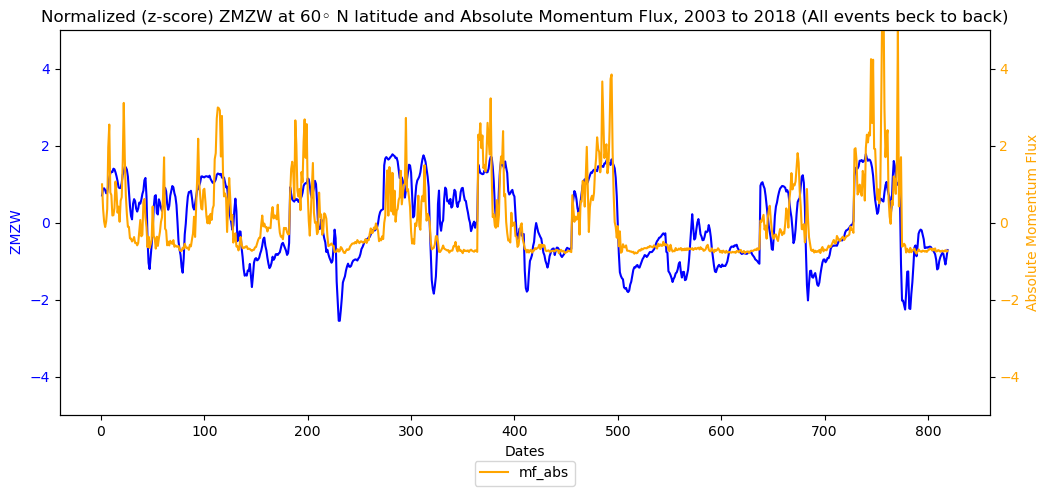

In [9]:
# =================================================================================================
# Plot normalized absolute Momemtum flux and ZMZW with Matplotlib
# =================================================================================================

import matplotlib.pyplot as plt

# Plot the data
fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.plot(df['index_'], df['wind_eastward_mean_cos'], color='blue', label='wind_eastward_mean_selection')
ax1.set_xlabel('Dates')
ax1.set_ylabel('ZMZW    ', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim([-5, 5])

ax2 = ax1.twinx()

ax2.plot(df['index_'], df['mf_abs'], color='orange', label='mf_abs')
ax2.set_ylabel('Absolute Momentum Flux', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.set_ylim([-5, 5])

# Add title and legend
plt.title('Normalized (z-score) ZMZW at 60◦ N latitude and Absolute Momentum Flux, 2003 to 2018 (All events beck to back)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

plt.show()


In [10]:
df_all['central_date'].unique()

array(['2003-01-17', '2004-01-02', '2006-01-22', '2007-02-22',
       '2008-02-22', '2009-01-23', '2010-03-21', '2013-01-07',
       '2018-02-11'], dtype=object)

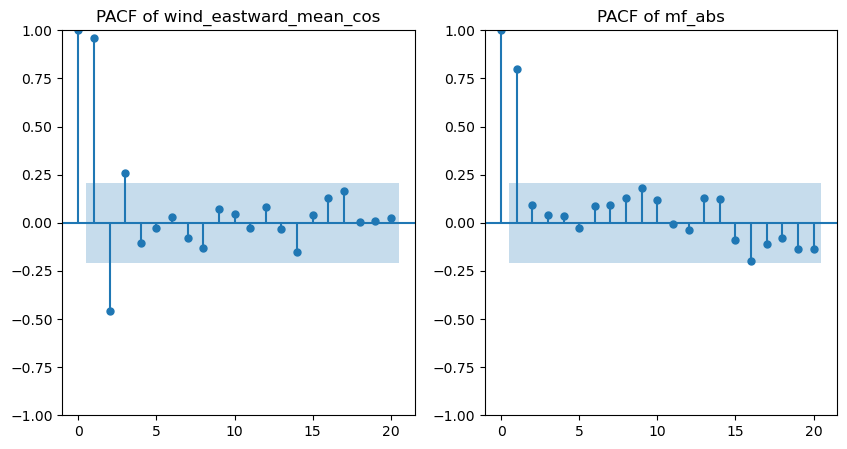

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 19, Apr, 2023
Time:                     14:09:02
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -3.65407
Nobs:                     86.0000    HQIC:                  -3.96103
Log likelihood:          -46.8432    FPE:                  0.0155106
AIC:                     -4.16777    Det(Omega_mle):       0.0127109
--------------------------------------------------------------------
Results for equation wind_eastward_mean_cos
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                            -0.011422         0.020816           -0.549           0.583
L1.wind_eastward_mean_cos         1.829517         0.107486           17.021           0

In [11]:
# =================================================================================================
# Run VAR for absolute momentum flux for 1 event
# =================================================================================================

# array(['2003-01-17', '2004-01-02', '2006-01-22', '2007-02-22',
#        '2008-02-22', '2009-01-23', '2010-03-21', '2013-01-07',
#        '2018-02-11'], dtype=object)

# new dataframe from sf_all where central_date is 2018-02-12

central_date = '2018-02-11'
dataframe = df_all[df_all['central_date'] == central_date]

var = 'mf_abs'

avgs = dataframe.mean(numeric_only=True)
devs = dataframe.std(numeric_only=True)

for col in [var, 'wind_eastward_mean_cos']:
    dataframe[col] = (dataframe[col] - avgs.loc[col]) / devs.loc[col]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# plot PACF of 'wind_eastward_mean_cos'
plot_pacf(dataframe['wind_eastward_mean_cos'], method='ywm', ax=ax1)
ax1.set_title('PACF of wind_eastward_mean_cos')

# plot PACF of 'mf_abs'
plot_pacf(dataframe[var], method='ywm', ax=ax2)
ax2.set_title(f'PACF of {var}')

plt.show()


for lag in range(1, 20):
    temp_series = dataframe[var].iloc[lag:]
    wind_series = dataframe['wind_eastward_mean_cos'].iloc[:-lag]
    # print('Lag: %s'%lag)
    # print(pearsonr(temp_series, wind_series))
    # print('------')

dataframe = dataframe[['wind_eastward_mean_cos',var]]
dataframe.diff().dropna()
dataframe = dataframe.reset_index(drop=True)


model = VAR(dataframe)
model_fit = model.fit(maxlags=10, ic='aic')

df_params = model_fit.params

model_fit.summary()



In [12]:
# lag_order = model_fit.k_ar
# model_fit.forecast(dataframe.values[-lag_order:], 5)
# model_fit.plot_forecast(10)

In [13]:
granger_causality_test = model_fit.test_causality('wind_eastward_mean_cos', [var], kind='f')

granger_causality_test.summary()

Test statistic,Critical value,p-value,df
4.145,2.430,0.003,"(4, 154)"


In [14]:

# =================================================================================================
# Run VAR for absolute momentum flux for ALL SSW events
# =================================================================================================

# group df by central_date

# central_dates

# =============> 2003-01-18
# =============> 2004-01-03
# =============> 2006-01-23
# =============> 2007-02-23
# =============> 2008-02-23
# =============> 2009-01-24
# =============> 2010-02-05
# =============> 2010-03-22
# =============> 2013-01-08
# =============> 2018-02-12

# Hold self correlation parameters
main_params_df_auto = pd.DataFrame()

# holdc correlation with var parameters
main_params_df_var = pd.DataFrame()

var = 'mf_abs'

df_grouped = df_all.groupby('central_date')

for central_date, dataframe in df_grouped:
    avgs = dataframe.mean(numeric_only=True)
    devs = dataframe.std(numeric_only=True)

    
    for col in [var, 'wind_eastward_mean_cos']:
        dataframe[col] = (dataframe[col] - avgs.loc[col]) / devs.loc[col]

    
    # plot_pacf(df['wind_eastward_mean_cos'])
    # plt.show()
    # plot_pacf(df['mf_abs'])
    # plt.show()


    for lag in range(1, 20):
        temp_series = dataframe[var].iloc[lag:]
        wind_series = dataframe['wind_eastward_mean_cos'].iloc[:-lag]
        # print('Lag: %s'%lag)
        # print(pearsonr(temp_series, wind_series))
        # print('------')

    dataframe = dataframe[['wind_eastward_mean_cos',var]]
    dataframe.diff().dropna()
    dataframe = dataframe.reset_index(drop=True)

    model = VAR(dataframe)
    model_fit = model.fit(maxlags=20)
    
    # =================================================================================================
    # Prep df_params for matrix plots
    # =================================================================================================

    df_params = model_fit.params

    # add name to first column in df_params
    df_params =df_params.reset_index()

    # exclude first row from df_params
    df_params = df_params.iloc[1:]

    standard_error = model_fit.pvalues
    # rename column headers in standard_error
    standard_error = standard_error.reset_index()
    standard_error = standard_error.rename(columns={'wind_eastward_mean_cos':'wind_eastward_mean_cos_se',var:f'{var}_se'})
    standard_error = standard_error.iloc[1:]


    # create a new column with the first two characters of index
    df_params['var'] = df_params['index'].str[:3]

    # create a new column with the the characters after the first two characters of index
    df_params['lag'] = df_params['index'].str[3:]

    df_params['var'] = df_params['var'].apply(lambda x: x.strip('.'))
    df_params['lag'] = df_params['lag'].apply(lambda x: x.strip('.'))

    # select only columns lag where it's equal to wind_eastward_mean_cos
    df_params_auto = df_params[df_params['lag'] == 'wind_eastward_mean_cos']
    
    df_params_var = df_params[df_params['lag'] == var]


    df_params_auto['identifier'] = central_date

    df_params_var['identifier'] = central_date


    df_params_auto = pd.merge(df_params_auto, standard_error, on=['index'])

    df_params_var = pd.merge(df_params_var, standard_error, on=['index'])

    # concatenate df_params to main_params_df
    main_params_df_auto = pd.concat([main_params_df_auto, df_params_auto])

    main_params_df_var = pd.concat([main_params_df_var, df_params_var])

In [15]:
# save model_fit.params to csv
params = model_fit.params
params.to_csv('params.csv')


In [16]:
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 19, Apr, 2023
Time:                     14:09:05
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -1.64352
Nobs:                     70.0000    HQIC:                  -3.23123
Log likelihood:           33.0600    FPE:                  0.0195290
AIC:                     -4.27747    Det(Omega_mle):      0.00776658
--------------------------------------------------------------------
Results for equation wind_eastward_mean_cos
                                coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------
const                             -0.048305         0.023158           -2.086           0.037
L1.wind_eastward_mean_cos          1.442959         0.181840            7.935        

In [17]:
# =================================================================================================
# get correlation coeficients for each identifier
# =================================================================================================
param_df = main_params_df_var

coefs_arr = []
for identifier, dataframe in param_df.groupby('identifier'):
    coefs_arr.append(dataframe['wind_eastward_mean_cos'].values)

# =================================================================================================
# get p values for each identifier
# =================================================================================================

coefs_arr_se = []
for identifier, dataframe in param_df.groupby('identifier'):
    coefs_arr_se.append(dataframe['wind_eastward_mean_cos_se'].values)

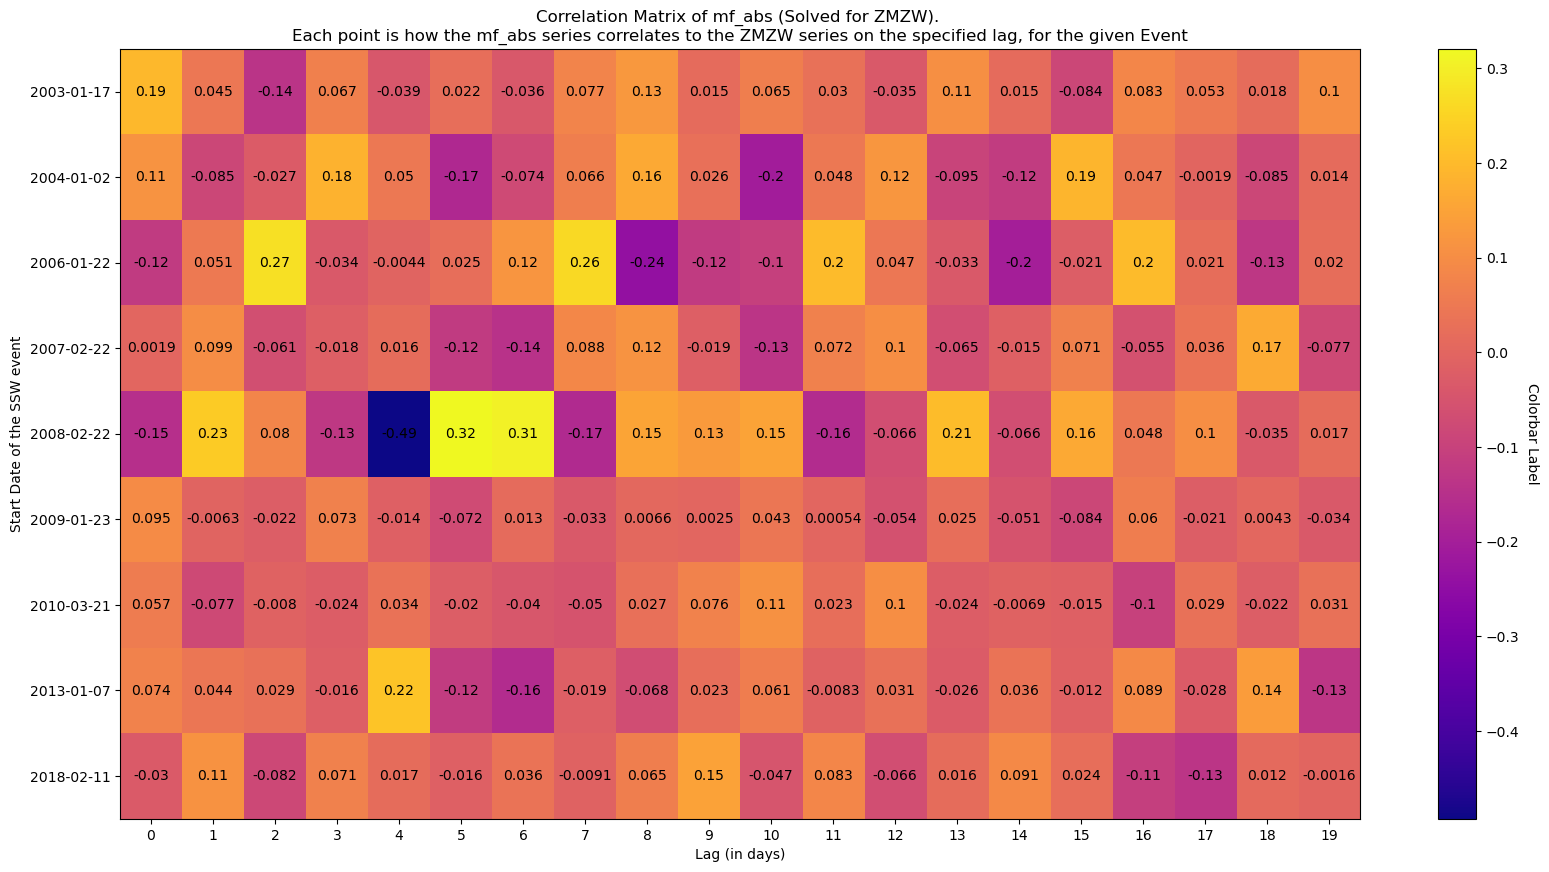

In [18]:
# =================================================================================================
# Plot p values for each identifier (SSW starte date) and lag, using matplotlib
# =================================================================================================

import matplotlib.pyplot as plt
import numpy as np

dates = param_df['identifier'].unique()
dates.sort()

fig, ax = plt.subplots(figsize=(20, 10))
im = ax.imshow(coefs_arr, aspect="auto",cmap='plasma')


# add title to the figure
ax.set_title(f"Correlation Matrix of {var} (Solved for ZMZW). \nEach point is how the {var} series correlates to the ZMZW series on the specified lag, for the given Event")

# Add row labels to the figure
tickvals = np.arange(len(dates))
ax.set_yticks(tickvals)
ax.set_yticklabels(dates)
ax.set_ylabel('Start Date of the SSW event')

ax.set_xticks(np.arange(np.shape(coefs_arr)[1]))
ax.set_xlabel('Lag (in days)')

# add color bar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Colorbar Label', rotation=-90, va="bottom")

# add numerical values to each box
for i in range(len(dates)):
    for j in range(np.shape(coefs_arr_se)[1]):
        text = ax.text(j, i, "{:.2g}".format(coefs_arr[i][j]),
                       ha="center", va="center", color="black")

plt.show()



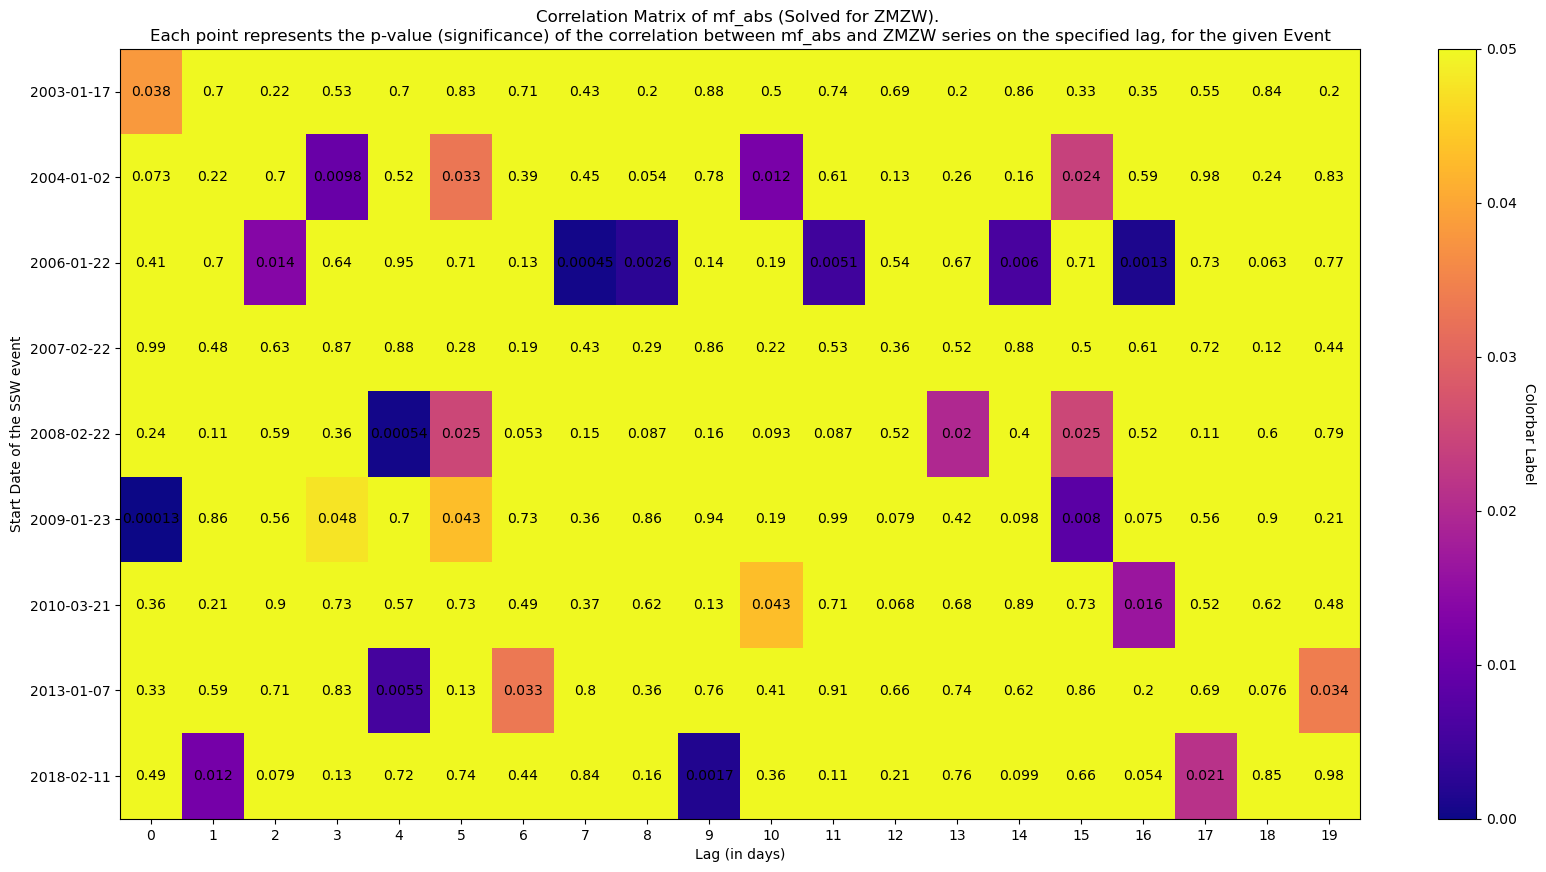

In [19]:
# =================================================================================================
# Plot p values for each identifier (SSW starte date) and lag, using matplotlib
# =================================================================================================

import matplotlib.pyplot as plt
import numpy as np

dates = param_df['identifier'].unique()
dates.sort()

fig, ax = plt.subplots(figsize=(20, 10))
im = ax.imshow(coefs_arr_se, aspect="auto",cmap='plasma')

# set the color gradient
im.set_clim(0, 0.05)

# add title to the figure
ax.set_title(f"Correlation Matrix of {var} (Solved for ZMZW). \nEach point represents the p-value (significance) of the correlation between {var} and ZMZW series on the specified lag, for the given Event")

# Add row labels to the figure
tickvals = np.arange(len(dates))
ax.set_yticks(tickvals)
ax.set_yticklabels(dates)
ax.set_ylabel('Start Date of the SSW event')

ax.set_xticks(np.arange(np.shape(coefs_arr_se)[1]))
ax.set_xlabel('Lag (in days)')

# add color bar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Colorbar Label', rotation=-90, va="bottom")

# add numerical values to each box
for i in range(len(dates)):
    for j in range(np.shape(coefs_arr_se)[1]):
        text = ax.text(j, i, "{:.2g}".format(coefs_arr_se[i][j]),
                       ha="center", va="center", color="black")

plt.show()

